In [15]:
# import modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from sklearn.neighbors import kneighbors_graph
import seaborn as sns

In [2]:
# load the data
data = np.load("Data/clusters_zred.npy")
ra0, dec0 = data['RA'].mean(), data['DEC'].mean()
X = np.dstack(((ra0-data['RA'])*np.cos(np.radians(data['DEC'])), data['DEC']-dec0, data['Z']))[0]  
m = len(data)   # number of data points

In [3]:
# creating an adjacency matrix
def adjacency(X, alphas):
    A = []    
    for alpha in alphas:
        a = (X[None, :, :] - X[:, None, :])**2                          # determine point correlations
        a2 = np.sqrt(a[:, :, 0:2].sum(axis=-1)) + alpha*a[:, :, 2]      # weight redshift by factor of alpha                                             # disconnect dissimilar edges
        A.append(a2)
    return A

# get a series of adjacency matrices for differet values of alpha
alphas = np.linspace(0, 1, 50)
A = adjacency(X, alphas)

In [5]:
# create trimmed MST
def trimmed_MST(X, A, perc):
    T = []
    ones = []
    twos = []
    for a in A:
        t = minimum_spanning_tree(a).toarray()
        cut = np.percentile(t[t > 0], [perc])[0]
        t[t > cut] = 0
        T.append(t)
        one, two = np.where(t > 0)
        ones.append(one), twos.append(two)
    return T, ones, twos

# create MST and cut at threshold
perc = 99
T, ones, twos = trimmed_MST(X, A, perc)

In [11]:
# determining the metric cost
def find_cost(X, a, k, labels):
    intra_dist = []
    mean_pos = []
    for cluster in range(k):
        curr = (labels == cluster)  # obtain all points in current cluster
        if (sum(curr) > 1):         # finding intra-cluster distances if there's more than one point
            mean_pos.append(X[curr].mean())
            dist = a[curr, :][:, curr]
            intra_dist.append(dist[dist > 0].mean())
    all_mean = a[a > 0].mean()
    inter_dist = np.stack(mean_pos, axis=0)
    return np.mean(intra_dist)/np.mean(inter_dist)/all_mean

# using tree-based metrics to get clustering result
def tbm(X, A, T):
    G = []
    cost = []
    K = []
    labels = []
    for i in range(len(T)):
        a = A[i]
        g = csr_matrix(T[i])
        G.append(g)
        k, label = connected_components(g)
        K.append(k), labels.append(label)
        c = find_cost(X, a, k, label)
        cost.append(c)
    return K, cost, labels

# determine the clusters in the trimmed MST
K, cost, labels = tbm(X, A, T)

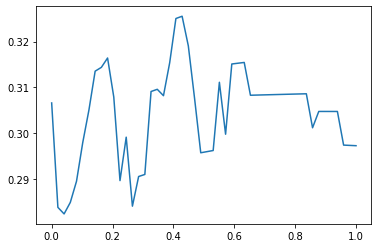

In [12]:
# plotting cost against alpha
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alphas, cost)

Text(0, 0.5, '$y$')

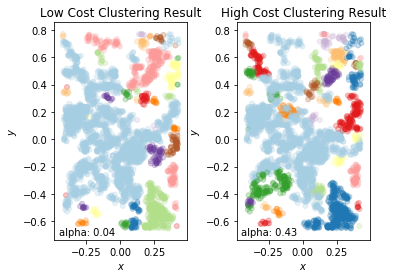

In [59]:
# plotting a clustering result
def plot(X, labels, alpha, ax):
    palette = sns.color_palette('Paired', len(labels))
    colours = [palette[i] if i >= 0 else (0.5, 0.5, 0.5) for i in labels]
    #cluster_colours = [sns.desaturate(x, p) for x, p in zip(colours, probs)]
    ax.scatter(X[:, 0], X[:, 1], s=25, c=colours, alpha=0.25)
    ax.text(-0.45, -0.7, "alpha: " + str(np.round(alpha, 2)))

# plot results 
fig = plt.figure()

# plot lowest cost clustering result
min_ind = np.where(cost == np.amin(cost))[0][0]
min_alpha = alphas[min_ind]
ax_low = fig.add_subplot(121, aspect='equal')
plot(X, labels[min_ind], min_alpha, ax_low)

# plot highest cost clustering result
max_ind = np.where(cost == np.amax(cost))[0][0]
max_alpha = alphas[max_ind]
ax_hi = fig.add_subplot(122, aspect='equal')
plot(X, labels[max_ind], max_alpha, ax_hi)

# label plots
ax_low.set_title("Low Cost Clustering Result")
ax_low.set_xlabel("$x$")
ax_low.set_ylabel("$y$")
ax_hi.set_title("High Cost Clustering Result")
ax_hi.set_xlabel("$x$")
ax_hi.set_ylabel("$y$")